# Trying New Data

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [219]:
HUMAN_COLOR = 'royalblue'
CHIMP_COLOR = 'darkorange'

### Reading df

### Clean Data  

In [137]:
def change_col_name(df, col:int):
    cell_name = col - ((col-2) % 4)
    df.iloc[1,col] = df.iloc[0,cell_name] + '_' + df.iloc[1,col]
    return cell_name

In [138]:
GENE_AXIS = 0
SAMPLE_AXIS = 1

# Reading the data
raw_df = pd.read_csv('ASE-HYBRID.csv', header=None, skiprows=[1,2] )

# Removing first 16 columns
raw_df = raw_df.iloc[:,16:-1]

samples = raw_df.iloc[0].dropna().values

# Renaming the columns
for i in range(2,raw_df.shape[1]):
    change_col_name(raw_df, i)

# Turning the changed row into the new header
raw_df.columns = raw_df.iloc[1,:]

# Removing the first two rows
raw_df = raw_df.drop([0,1])
cols_to_drop = [col for col in raw_df.columns if 'ambig' in col] + ['chrom']
raw_df = raw_df.drop(columns=cols_to_drop)
raw_df.index = raw_df['gene']
raw_df = raw_df[np.logical_not(raw_df.index.duplicated(keep="first"))]  # Keep only the first occurrence

raw_df = raw_df.drop(columns=['gene'])

# The simplified df is without the non-esential columns
simplified_df = raw_df.astype(float)
simplified_df

C:\Users\wmata\AppData\Local\Temp\ipykernel_828\2832121809.py:5: DtypeWarning: Columns (0,1,8,9,10,11,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('ASE-HYBRID.csv', header=None, skiprows=[1,2] )


1,HL1-25_1_ref_counts,HL1-25_1_alt_counts,HL1-25_1_no_ase_counts,HL1-25_2_ref_counts,HL1-25_2_alt_counts,HL1-25_2_no_ase_counts,HL1-29_1_ref_counts,HL1-29_1_alt_counts,HL1-29_1_no_ase_counts,HL1-29_2_ref_counts,...,CNCC_H20961_3_no_ase_counts,CNCC_C3649_1_ref_counts,CNCC_C3649_1_alt_counts,CNCC_C3649_1_no_ase_counts,CNCC_C3649_2_ref_counts,CNCC_C3649_2_alt_counts,CNCC_C3649_2_no_ase_counts,CNCC_C3649_3_ref_counts,CNCC_C3649_3_alt_counts,CNCC_C3649_3_no_ase_counts
gene,,,,,,,,,,,,,,,,,,,,,
3.8-1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.8-1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.8-1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-HT3C2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG,39.0,70.0,59.0,65.0,92.0,104.0,50.0,79.0,75.0,58.0,...,98.0,0.0,111.0,60.0,0.0,177.0,80.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,450.0,753.0,888.0,535.0,980.0,1058.0,418.0,713.0,831.0,462.0,...,1112.0,0.0,338.0,464.0,0.0,691.0,867.0,1.0,1215.0,1039.0
ZYX,3917.0,4570.0,1618.0,6926.0,8019.0,3712.0,3901.0,4161.0,1727.0,5462.0,...,1300.0,4.0,1254.0,464.0,6.0,2344.0,704.0,4.0,250.0,124.0
ZZEF1,552.0,423.0,617.0,703.0,549.0,818.0,456.0,403.0,505.0,681.0,...,984.0,2.0,638.0,584.0,2.0,1066.0,989.0,2.0,941.0,730.0


### Parse the sample types
There are several types of cells and samples, splitting into overlapsing categories: 

__Sample Types:__ Hybrid Cells, Human Cells, Chimp Cells

__Cell Type:__ iPSC (induced Plurypotent Stem Cells), CNCC (Cranial Neural Crest Cell)

__mRNA Read Type (Reffered as COUNTS):__ Reference Counts - mRNA reads of Human Gene, Alternative Counts - mRNA reads of Chimp Gene 

Dataset  = Sample_Types X Cell_Types X Read_Types

So, there are samples that are Human-iPSC-Ref, Hybrid-CNCC-Alt and all possible combos 


In [139]:
HYBRIDS_SAMPLES = set([s for s in simplified_df.columns if 'HL' in s])
non_hybrid = set(simplified_df.columns) - HYBRIDS_SAMPLES
HUMAN_SAMPLES = set([s for s in non_hybrid if 'H' in s])
CHIMP_SAMPLES = non_hybrid - HUMAN_SAMPLES
REF_COUNT = set([s for s in simplified_df.columns if 'ref' in s])
ALT_COUNT = set([s for s in simplified_df.columns if 'alt' in s])
NO_ASE_COUNT = set([s for s in simplified_df.columns if 'no_ase' in s])
CNCC = set([s for s in simplified_df.columns if 'CNCC' in s])
IPSC = set(simplified_df.columns) - CNCC

SAMPLES = {}
for s in samples:
    SAMPLES[s] = []


def intersect(list_of_categories):
    """This function takes a list of categories and returns the intersection of the samples that belong to those categories
    Will be used to specify the columns in the DF which we want to work with"""
    return sorted(list(set.intersection(*list_of_categories)))





### Cleaning the DF from meaningless genes 

In [140]:
print("Shape before filtering:", simplified_df.shape)

# Filtering the data - removing redundant genes
# human_chimp_gene_expression_columns = REF_COUNT.union(ALT_COUNT)
clean_df = simplified_df[simplified_df.loc[:,list(REF_COUNT.union(ALT_COUNT))].gt(50).any(axis=1)]
print("Shape after filtering:", clean_df.shape)
clean_df


Shape before filtering: (45946, 93)
Shape after filtering: (16260, 93)


1,HL1-25_1_ref_counts,HL1-25_1_alt_counts,HL1-25_1_no_ase_counts,HL1-25_2_ref_counts,HL1-25_2_alt_counts,HL1-25_2_no_ase_counts,HL1-29_1_ref_counts,HL1-29_1_alt_counts,HL1-29_1_no_ase_counts,HL1-29_2_ref_counts,...,CNCC_H20961_3_no_ase_counts,CNCC_C3649_1_ref_counts,CNCC_C3649_1_alt_counts,CNCC_C3649_1_no_ase_counts,CNCC_C3649_2_ref_counts,CNCC_C3649_2_alt_counts,CNCC_C3649_2_no_ase_counts,CNCC_C3649_3_ref_counts,CNCC_C3649_3_alt_counts,CNCC_C3649_3_no_ase_counts
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,39.0,70.0,59.0,65.0,92.0,104.0,50.0,79.0,75.0,58.0,...,98.0,0.0,111.0,60.0,0.0,177.0,80.0,0.0,1.0,4.0
A1BG-AS1,40.0,49.0,8.0,68.0,66.0,11.0,46.0,49.0,8.0,33.0,...,10.0,0.0,38.0,4.0,0.0,53.0,7.0,0.0,59.0,1.0
A2M,1.0,13.0,6.0,21.0,40.0,51.0,3.0,11.0,11.0,4.0,...,3642.0,6.0,143.0,154.0,6.0,243.0,220.0,5.0,5.0,8.0
A2ML1,129.0,50.0,57.0,101.0,33.0,62.0,178.0,37.0,94.0,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
A4GALT,154.0,79.0,107.0,85.0,51.0,53.0,140.0,94.0,96.0,73.0,...,1.0,0.0,1.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,20.0,51.0,31.0,28.0,87.0,48.0,27.0,69.0,44.0,26.0,...,1.0,0.0,8.0,3.0,0.0,17.0,9.0,0.0,84.0,30.0
ZYG11B,450.0,753.0,888.0,535.0,980.0,1058.0,418.0,713.0,831.0,462.0,...,1112.0,0.0,338.0,464.0,0.0,691.0,867.0,1.0,1215.0,1039.0
ZYX,3917.0,4570.0,1618.0,6926.0,8019.0,3712.0,3901.0,4161.0,1727.0,5462.0,...,1300.0,4.0,1254.0,464.0,6.0,2344.0,704.0,4.0,250.0,124.0


### Normalize Into Counts per Million

In [141]:
# Normalizing the counts to TPM - Transcripts Per Million
normalized_df = pd.DataFrame(index=clean_df.index)

COLUMNS_PER_SAMPLE = 3
for i in range(0, clean_df.shape[1], COLUMNS_PER_SAMPLE):
    sample_window = clean_df.iloc[:, i:i + COLUMNS_PER_SAMPLE]
    total_sample_counts = sample_window.sum()
    normalized_df[sample_window.columns] = (1e6 * sample_window / total_sample_counts).astype(float)

normalized_df

,HL1-25_1_ref_counts,HL1-25_1_alt_counts,HL1-25_1_no_ase_counts,HL1-25_2_ref_counts,HL1-25_2_alt_counts,HL1-25_2_no_ase_counts,HL1-29_1_ref_counts,HL1-29_1_alt_counts,HL1-29_1_no_ase_counts,HL1-29_2_ref_counts,...,CNCC_H20961_3_no_ase_counts,CNCC_C3649_1_ref_counts,CNCC_C3649_1_alt_counts,CNCC_C3649_1_no_ase_counts,CNCC_C3649_2_ref_counts,CNCC_C3649_2_alt_counts,CNCC_C3649_2_no_ase_counts,CNCC_C3649_3_ref_counts,CNCC_C3649_3_alt_counts,CNCC_C3649_3_no_ase_counts
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,4.270029,7.359367,3.482333,5.466071,7.429523,4.204257,5.782179,8.977048,4.404674,5.629933,...,5.752120,0.000000,16.730917,7.402199,0.000000,14.684412,5.831374,0.000000,0.095826,0.353399
A1BG-AS1,4.379517,5.151557,0.472181,5.718351,5.329875,0.444681,5.319605,5.568043,0.469832,3.203238,...,0.586951,0.000000,5.727701,0.493480,0.000000,4.397027,0.510245,0.000000,5.653763,0.088350
A2M,0.109488,1.366740,0.354136,1.765961,3.230227,2.061703,0.346931,1.249969,0.646019,0.388271,...,213.767546,400.828379,21.554245,18.998978,410.480947,20.159956,16.036279,300.625301,0.479132,0.706799
A2ML1,14.123941,5.256691,3.364288,8.493433,2.664938,2.506384,20.584557,4.204440,5.520525,10.289187,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095826,0.000000
A4GALT,16.861139,8.305572,6.315418,7.147939,4.118540,2.142554,16.190101,10.681551,5.637983,7.085950,...,0.058695,0.000000,0.150729,0.000000,0.000000,0.248888,0.145784,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,2.189758,5.361825,1.829701,2.354615,7.025745,1.940426,3.122377,7.840713,2.584076,2.523763,...,0.058695,0.000000,1.205832,0.370110,0.000000,1.410367,0.656030,0.000000,8.049426,2.650494
ZYG11B,49.269562,79.165767,52.412068,44.989968,79.140572,42.770232,48.339017,81.020702,48.803793,44.845326,...,65.268949,0.000000,50.946397,57.243675,0.000000,57.327281,63.197519,60.125060,116.429194,91.795456
ZYX,428.864168,480.461563,95.498565,582.430871,647.579845,150.059642,451.125611,472.829088,101.424971,530.184350,...,76.303627,267.218919,189.014148,57.243675,410.480947,194.464756,51.316094,240.500241,23.956624,10.955377


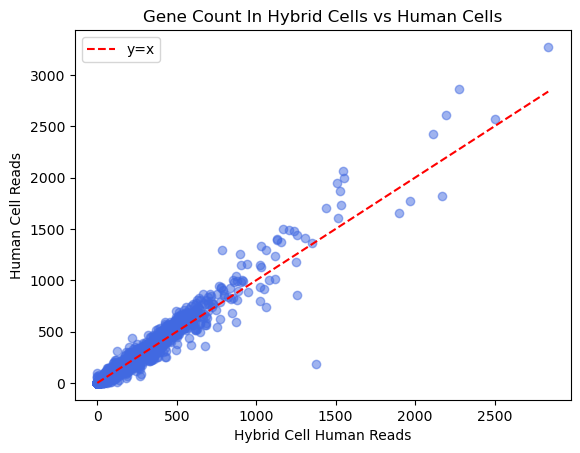

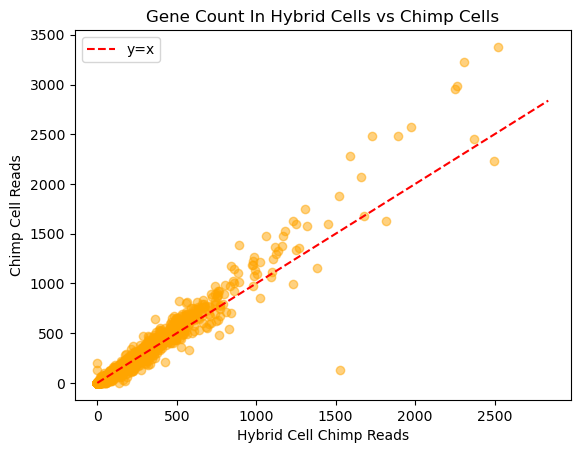

In [ ]:
df_compare_hybrid_vs_parental_scatter = pd.DataFrame(index=normalized_df.index)
df_compare_hybrid_vs_parental_scatter.loc[:, 'hybrid_ref_avg'] = (normalized_df.loc[:, intersect([IPSC, HYBRIDS_SAMPLES, REF_COUNT])].mean(axis=1))
df_compare_hybrid_vs_parental_scatter.loc[:, 'hybrid_alt_avg'] = (normalized_df.loc[:, intersect([IPSC, HYBRIDS_SAMPLES, ALT_COUNT])].mean(axis=1))
df_compare_hybrid_vs_parental_scatter.loc[:, 'parental_ref_avg'] = (normalized_df.loc[:, intersect([IPSC, HUMAN_SAMPLES, REF_COUNT])].mean(axis=1))
df_compare_hybrid_vs_parental_scatter.loc[:, 'parental_alt_avg'] = (normalized_df.loc[:, intersect([IPSC, CHIMP_SAMPLES, ALT_COUNT])].mean(axis=1))





plt.scatter(df_compare_hybrid_vs_parental_scatter['hybrid_ref_avg'], df_compare_hybrid_vs_parental_scatter['parental_ref_avg'], color=HUMAN_COLOR, alpha=0.5)
plt.title('Gene Count In Hybrid Cells vs Human Cells')
plt.xlabel('Hybrid Cell Human Reads')
plt.ylabel('Human Cell Reads')
# Add y=x line
plt.plot([df_compare_hybrid_vs_parental_scatter['hybrid_ref_avg'].min(), df_compare_hybrid_vs_parental_scatter['hybrid_ref_avg'].max()],
         [df_compare_hybrid_vs_parental_scatter['hybrid_ref_avg'].min(), df_compare_hybrid_vs_parental_scatter['hybrid_ref_avg'].max()],
         color='red', linestyle='--', label='y=x')
# df_compare_hybrid_vs_parental_scatter.loc[:,['hybrid_ref_avg', 'parental_ref_avg']]
plt.legend()
plt.show() 


plt.scatter(df_compare_hybrid_vs_parental_scatter['hybrid_alt_avg'], df_compare_hybrid_vs_parental_scatter['parental_alt_avg'], color=CHIMP_COLOR, alpha=0.5)
plt.title('Gene Count In Hybrid Cells vs Chimp Cells')
plt.xlabel('Hybrid Cell Chimp Reads')
plt.ylabel('Chimp Cell Reads')
# Add y=x line
plt.plot([df_compare_hybrid_vs_parental_scatter['hybrid_ref_avg'].min(), df_compare_hybrid_vs_parental_scatter['hybrid_ref_avg'].max()],
         [df_compare_hybrid_vs_parental_scatter['hybrid_ref_avg'].min(), df_compare_hybrid_vs_parental_scatter['hybrid_ref_avg'].max()],
         color='red', linestyle='--', label='y=x')
# df_compare_hybrid_vs_parental_scatter.loc[:,['hybrid_ref_avg', 'parental_ref_avg']]
plt.legend()
plt.show()


### Find Genes with Similar Distribution  in Both Hybrid and Parenthal Samples
Motivation: 

Human-Chimp Hybrid Cells are **Tetraploids**, meaning that from each chromosome they have two copies of the Human Version and additional two copies of the Chimp Version. As human and chimp DNA is very similar, Human Regulatory Elements such as Transcition Factors may interfere with Chimpanzee Gene Expression, and vice versa, Chimp Regulatory Elements may interfere with Human Gene expression. As we wish to compare Human Gene activity to Chimp Gene activity, we need to ignore cases in which Hybrid-Cell gene expression is interfered. We would like to ensure that Human-Genes are expressed in Hyrbrid cells similarly as in Human cells, and that Chimp Genes are expressed in Hybrid cells similarly as in Chimp Cells.

We used two different methods to check which genes are expressed similarly in between the Hybrid Cells and the Parental Cells. Here, we use the traditional Wilcoxon test, where the $H_0$ Hypothesis is that the genes expressions between the cell types (Hybrid-Human and Hybrid-Chimp) come in the same distribution, and $H_1$ Hypothesis is that they come from different distributions. This time we were looking for a High P-Value, which is equivalent to certainty to be from the same distribution. 

The other method we used was the TOST test. This is a test is based on doing two times one-sided Wilcoxon Test, that checks if two groups are equivalent withing some acceptable gap Epsilon. 


In [143]:
from scipy.stats import ttest_ind, mannwhitneyu

def get_p_values_paired_wilcoxon(gene):
    human_h_values = normalized_df.loc[gene, intersect([HUMAN_SAMPLES, REF_COUNT, IPSC])]
    hybrid_h_vlaues = normalized_df.loc[gene, intersect([HYBRIDS_SAMPLES, REF_COUNT, IPSC])]
    hybrid_c_values = normalized_df.loc[gene, intersect([HYBRIDS_SAMPLES, ALT_COUNT, IPSC])]
    chimp_c_values = normalized_df.loc[gene, intersect([CHIMP_SAMPLES, ALT_COUNT, IPSC])]
    
    _, p_val_wilcoxon_hybrid_human = mannwhitneyu(human_h_values, hybrid_h_vlaues, alternative='two-sided')
    _, p_val_wilcoxon_hybrid_chimp = mannwhitneyu(hybrid_c_values, chimp_c_values, alternative='two-sided')
    # _, p_val_ttest_hybrid_human = ttest_ind(human_h_values, hybrid_h_vlaues, equal_var=False, alternative='two-sided')
    # _, p_val_ttest_hybrid_chimp = ttest_ind(hybrid_c_values, chimp_c_values, equal_var=False, alternative='two-sided')
    return{ 
            'p_val_wilcoxon_hybrid_human': p_val_wilcoxon_hybrid_human,
            'p_val_wilcoxon_hybrid_chimp': p_val_wilcoxon_hybrid_chimp,
            # 'p_val_ttest_hybrid_human': p_val_ttest_hybrid_human,
            # 'p_val_ttest_hybrid_chimp': p_val_ttest_hybrid_chimp
            }


p_values_DE = pd.DataFrame(index=normalized_df.index, columns=['p_val_wilcoxon_hybrid_human', 'p_val_wilcoxon_hybrid_chimp',
                                                #   'p_val_ttest_hybrid_human', 'p_val_ttest_hybrid_chimp'
                                                  ])
for gene in normalized_df.index: 
    p_values_DE.loc[gene] = get_p_values_paired_wilcoxon(gene)


Process how many genes are equvalent in Hybrid-Parental...

In [178]:
p_val_threshold = 0.5

print('---------------------------------')
print('\tWilcoxon test results')
print("Hybrid && Human Genes:\t", (p_values_DE.loc[:,'p_val_wilcoxon_hybrid_human'] > p_val_threshold).sum())
print("Hybrid && Chimp Genes:\t", (p_values_DE.loc[:,'p_val_wilcoxon_hybrid_chimp'] > p_val_threshold).sum())
high_p_values_wilcoxon = np.logical_and(p_values_DE.loc[:, 'p_val_wilcoxon_hybrid_human'] > p_val_threshold, p_values_DE.loc[:, 'p_val_wilcoxon_hybrid_chimp'] > p_val_threshold)
print("Both:\t\t\t", high_p_values_wilcoxon.sum())

print('---------------------------------')
# print('\tT-test results')
# print("Hybrid && Human Genes:\t", (p_values.loc[:,'p_val_ttest_hybrid_human'] > p_val_threshold).sum())
# print("Hybrid && Chimp Genes:\t", (p_values.loc[:,'p_val_ttest_hybrid_chimp'] > p_val_threshold).sum())
# high_p_values_ttest = np.logical_and(p_values.loc[:, 'p_val_ttest_hybrid_human'] > p_val_threshold, p_values.loc[:, 'p_val_ttest_hybrid_chimp'] > p_val_threshold)
# print("Both:\t\t\t", high_p_values_ttest.sum())
# print('---------------------------------')

selected_wilcoxon_equivalent_genes = normalized_df.index[high_p_values_wilcoxon]
expressed_in_ISPC_genes = normalized_df.loc[selected_wilcoxon_equivalent_genes, intersect([IPSC, HYBRIDS_SAMPLES, REF_COUNT])].sum(axis=1) > 0
selected_wilcoxon_equivalent_genes = selected_wilcoxon_equivalent_genes[expressed_in_ISPC_genes]

---------------------------------
	Wilcoxon test results
Hybrid && Human Genes:	 4784
Hybrid && Chimp Genes:	 4845
Both:			 1662
---------------------------------


In [180]:
selected_wilcoxon_equivalent_genes.size

1646

### TOST - Two One-Sided Test - Trying to find genes with consistant distribution 
The TOST test is to show that two groups belong to the same distribution. In this case we are trying to identify genes that the Hybrid cells are distributing similarly to the parental cells. 



In [145]:

def tost_test(gene, epsilon):
    human_h_values = normalized_df.loc[gene, intersect([HUMAN_SAMPLES, REF_COUNT, IPSC])]
    hybrid_h_values = normalized_df.loc[gene, intersect([HYBRIDS_SAMPLES, REF_COUNT, IPSC])]
    hybrid_c_values = normalized_df.loc[gene, intersect([HYBRIDS_SAMPLES, ALT_COUNT, IPSC])]
    chimp_c_values = normalized_df.loc[gene, intersect([CHIMP_SAMPLES, ALT_COUNT, IPSC])]

    _, lower_bound_p_val_hybrid_human = mannwhitneyu(human_h_values, hybrid_h_values - epsilon, alternative='greater')
    _, upper_bound_p_val_hybrid_human = mannwhitneyu(human_h_values, hybrid_h_values + epsilon, alternative='less')
    _, lower_bound_p_val_hybrid_chimp = mannwhitneyu(hybrid_c_values, chimp_c_values - epsilon, alternative='greater')
    _, upper_bound_p_val_hybrid_chimp = mannwhitneyu(hybrid_c_values, chimp_c_values + epsilon, alternative='less')

    # lower_bound_p_val_hybrid_human = ttest_ind(human_h_values, hybrid_h_values - epsilon, equal_var=False)[1] / 2
    # upper_bound_p_val_hybrid_human = ttest_ind(human_h_values, hybrid_h_values + epsilon, equal_var=False)[1] / 2
    # lower_bound_p_val_hybrid_chimp = ttest_ind(hybrid_c_values, chimp_c_values - epsilon, equal_var=False)[1] / 2
    # upper_bound_p_val_hybrid_chimp = ttest_ind(hybrid_c_values, chimp_c_values + epsilon, equal_var=False)[1] / 2

    return {
        'lower_bound_p_val_hybrid_human': lower_bound_p_val_hybrid_human,
        'upper_bound_p_val_hybrid_human': upper_bound_p_val_hybrid_human,
        'lower_bound_p_val_hybrid_chimp': lower_bound_p_val_hybrid_chimp,
        'upper_bound_p_val_hybrid_chimp': upper_bound_p_val_hybrid_chimp,
    }


tost_p_values = pd.DataFrame(index=selected_wilcoxon_equivalent_genes, columns=['lower_bound_p_val_hybrid_human', 
                                                                    'upper_bound_p_val_hybrid_human', 
                                                                    'lower_bound_p_val_hybrid_chimp',
                                                                    'upper_bound_p_val_hybrid_chimp'
                                                                    ])
for gene in normalized_df.index: 
    tost_p_values.loc[gene] = tost_test(gene, epsilon=0.6)




C:\Users\wmata\AppData\Local\Temp\ipykernel_828\1620538058.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tost_p_values.loc[gene] = tost_test(gene, epsilon=0.6)


In [146]:
human_hybrid_tost_equivalence = np.maximum(tost_p_values['lower_bound_p_val_hybrid_human'], tost_p_values['upper_bound_p_val_hybrid_human']) < 0.05
chimp_hybrid_tost_equivalence = np.maximum(tost_p_values['lower_bound_p_val_hybrid_chimp'], tost_p_values['upper_bound_p_val_hybrid_chimp']) < 0.05

print('---------------------------------')
print('\tTOST test results')
print("Hybrid && Human Genes:\t", human_hybrid_tost_equivalence.sum())
print("Hybrid && Chimp Genes:\t", chimp_hybrid_tost_equivalence.sum())
tost_equivalent_genes = normalized_df.index[np.logical_and(human_hybrid_tost_equivalence, chimp_hybrid_tost_equivalence)]
print('Both:\t\t\t', tost_equivalent_genes.shape[0])
print('---------------------------------')


---------------------------------
	TOST test results
Hybrid && Human Genes:	 1209
Hybrid && Chimp Genes:	 1242
Both:			 790
---------------------------------


### Compare Hybrid Expression to Parental Expression
This is to filter out genes that get too messy with the the tetraploidism

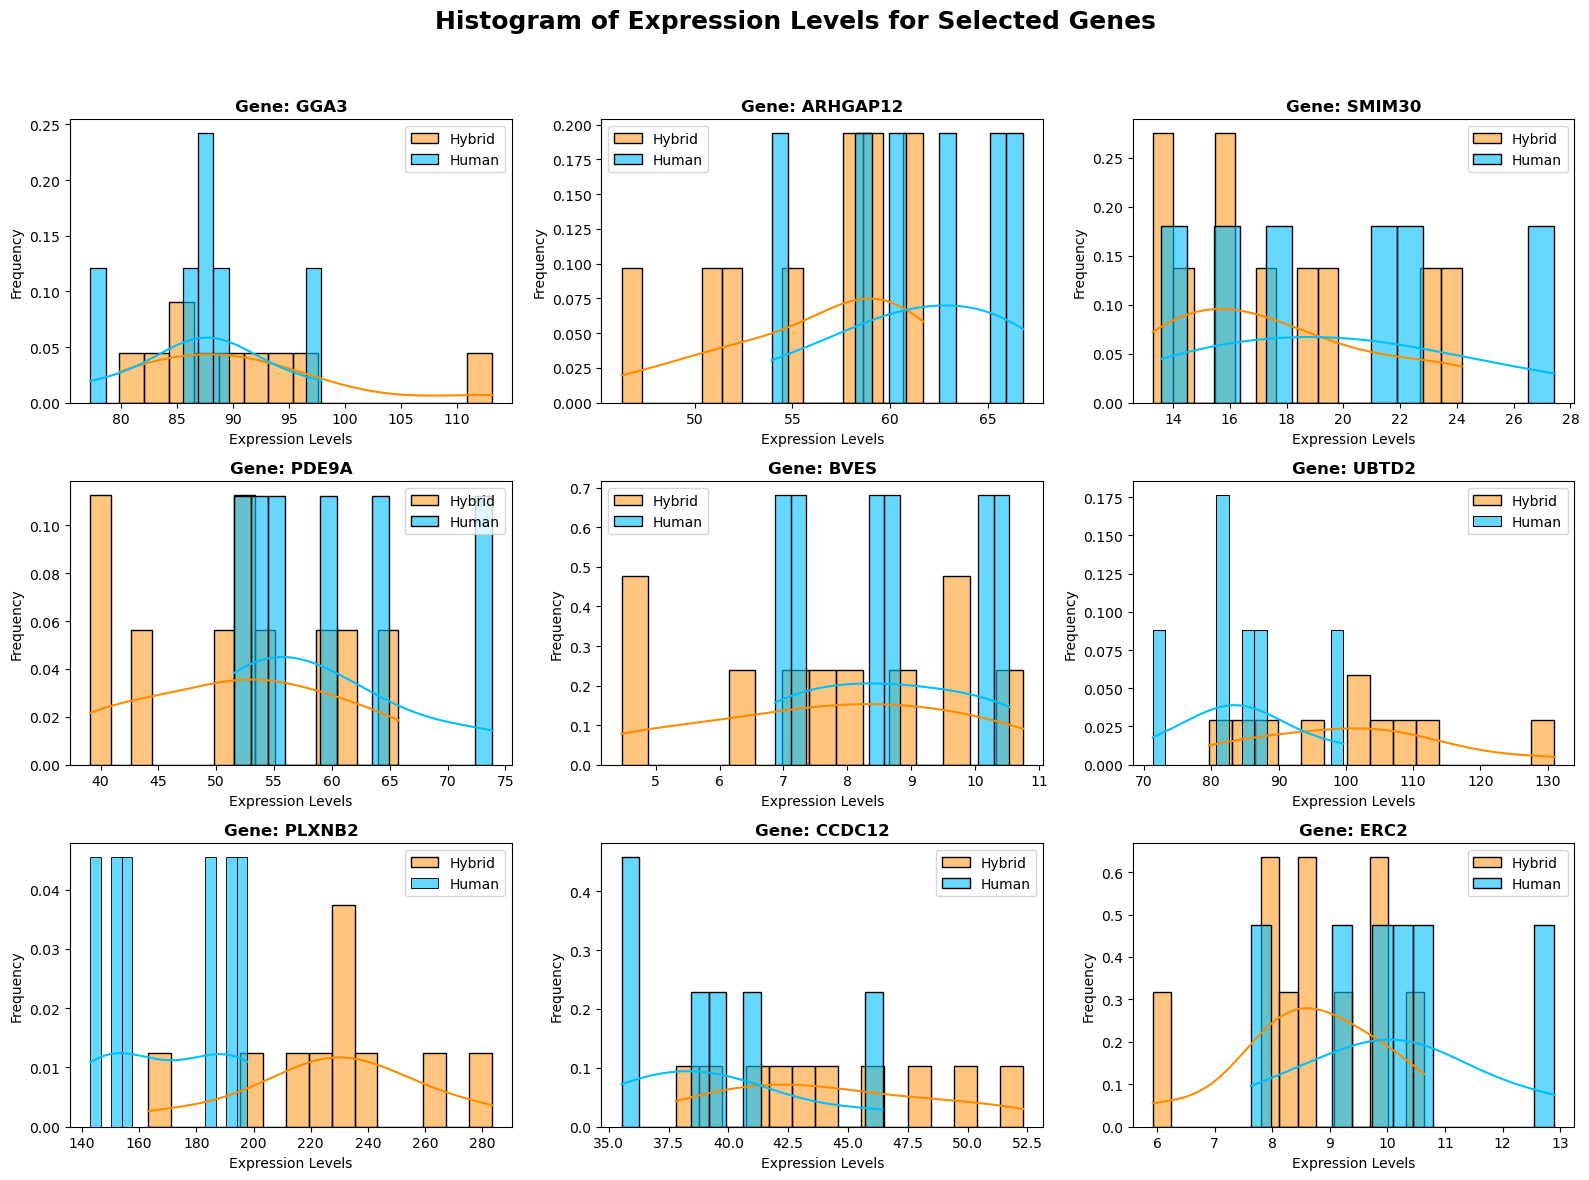

In [147]:
# Set random seed for reproducibility
np.random.seed(1999)

SAMPLE_AMOUNT = 9
selected_genes = np.random.choice(tost_equivalent_genes, min(SAMPLE_AMOUNT, len(tost_equivalent_genes)), replace=False)

# Define colors
hybrid_h = 'darkorange'
parental_h = 'deepskyblue'

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
fig.suptitle('Histogram of Expression Levels for Selected Genes', fontsize=18, fontweight='bold')
axes = axes.flatten()

# Plot histograms for each gene
for i, gene in enumerate(selected_genes):
    ax = axes[i]

    # Extract expression values
    df_hybrid_h_ipsc = normalized_df.loc[gene, intersect([IPSC, HYBRIDS_SAMPLES, REF_COUNT])]
    df_human_h_ipsc = normalized_df.loc[gene, intersect([IPSC, HUMAN_SAMPLES, REF_COUNT])]

    # Plot using seaborn histplot for better visualization
    sns.histplot(df_hybrid_h_ipsc, bins=15, kde=True, alpha=0.5, color=hybrid_h, label='Hybrid', ax=ax, stat="density")
    sns.histplot(df_human_h_ipsc, bins=15, kde=True, alpha=0.6, color=parental_h, label='Human', ax=ax, stat="density")

    ax.set_xlabel('Expression Levels')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Gene: {gene}', fontsize=12, fontweight='bold')

    ax.legend()

# Hide empty subplots (if less than 20 genes)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()


### Comparing Human-Chimp Gene Expression in Hybrid Cells 

In [148]:
def get_p_values_independant_wilcoxon(group1, group2, group1_greater_name, group2_greater_name):
    
    _, p_wilcoxon_group1_overexpressed = mannwhitneyu(group1, group2, alternative='greater')
    _, p_wilcoxon_group1_underexpressed = mannwhitneyu(group1, group2, alternative='less')
    
    return{
            group1_greater_name: p_wilcoxon_group1_overexpressed,
            group2_greater_name: p_wilcoxon_group1_underexpressed
            }



In [210]:
from scipy.stats import wilcoxon, ttest_rel

def get_p_values_paired_wilcoxon(group1_2_gap, group1_greater_name, group2_greater_name):
    
    _, p_wilcoxon_group1_overexpressed = wilcoxon(group1_2_gap, alternative='greater')
    _, p_wilcoxon_group1_underexpressed = wilcoxon(group1_2_gap, alternative='less')
    if(p_wilcoxon_group1_overexpressed is np.nan or p_wilcoxon_group1_underexpressed is np.nan): 
        print(f"{gene} showed NAN")
    return{
            group1_greater_name: p_wilcoxon_group1_overexpressed,
            group2_greater_name: p_wilcoxon_group1_underexpressed
            }



In [212]:

# df_hybrids_iPSC = normalized_df.loc[: ,intersect([HYBRIDS_SAMPLES, IPSC])]

p_values_DE_hybrids_paired_wilcoxon = pd.DataFrame(index=selected_wilcoxon_equivalent_genes, columns=['p_wilcoxon_human_overexpressed', 'p_wilcoxon_human_underexpressed'])
for gene in selected_wilcoxon_equivalent_genes: 
    
    refs_gene = normalized_df.loc[gene, intersect([REF_COUNT, IPSC, HYBRIDS_SAMPLES])]
    alts_gene = normalized_df.loc[gene, intersect([ALT_COUNT, IPSC, HYBRIDS_SAMPLES])]
    refs_gene_gap = refs_gene.values - alts_gene.values
    # print(gene)
    p_values_DE_hybrids_paired_wilcoxon.loc[gene] = get_p_values_paired_wilcoxon(group1_2_gap=refs_gene_gap, group1_greater_name='p_wilcoxon_human_overexpressed', 
                                                          group2_greater_name='p_wilcoxon_human_underexpressed')

p_values_DE_hybrids_paired_wilcoxon[p_values_DE_hybrids_paired_wilcoxon['p_wilcoxon_human_overexpressed'] < 0.05].shape[0]



606

In [ ]:
genes_overexpressed_human = p_values_DE_hybrids_paired_wilcoxon[p_values_DE_hybrids_paired_wilcoxon['p_wilcoxon_human_overexpressed'] < 0.05].index
genes_underexpressed_human = p_values_DE_hybrids_paired_wilcoxon[p_values_DE_hybrids_paired_wilcoxon['p_wilcoxon_human_underexpressed'] < 0.05].index
print('---------------------------------')
print('Genes overexpressed in human cells:', genes_overexpressed_human.size)
print('Genes underexpressed in human cells:', genes_underexpressed_human.size)
print('---------------------------------')

top_60_overexpressed_genes = p_values_DE_hybrids_paired_wilcoxon.loc[:,'p_wilcoxon_human_overexpressed'].sort_values().head(60).index
top_60_underexpressed_genes = p_values_DE_hybrids_paired_wilcoxon.loc[:,'p_wilcoxon_human_underexpressed'].sort_values().head(60).index
top_120_genes = np.concatenate((top_60_overexpressed_genes, top_60_underexpressed_genes))




---------------------------------
Genes overexpressed in human cells: 606
Genes underexpressed in human cells: 551
---------------------------------


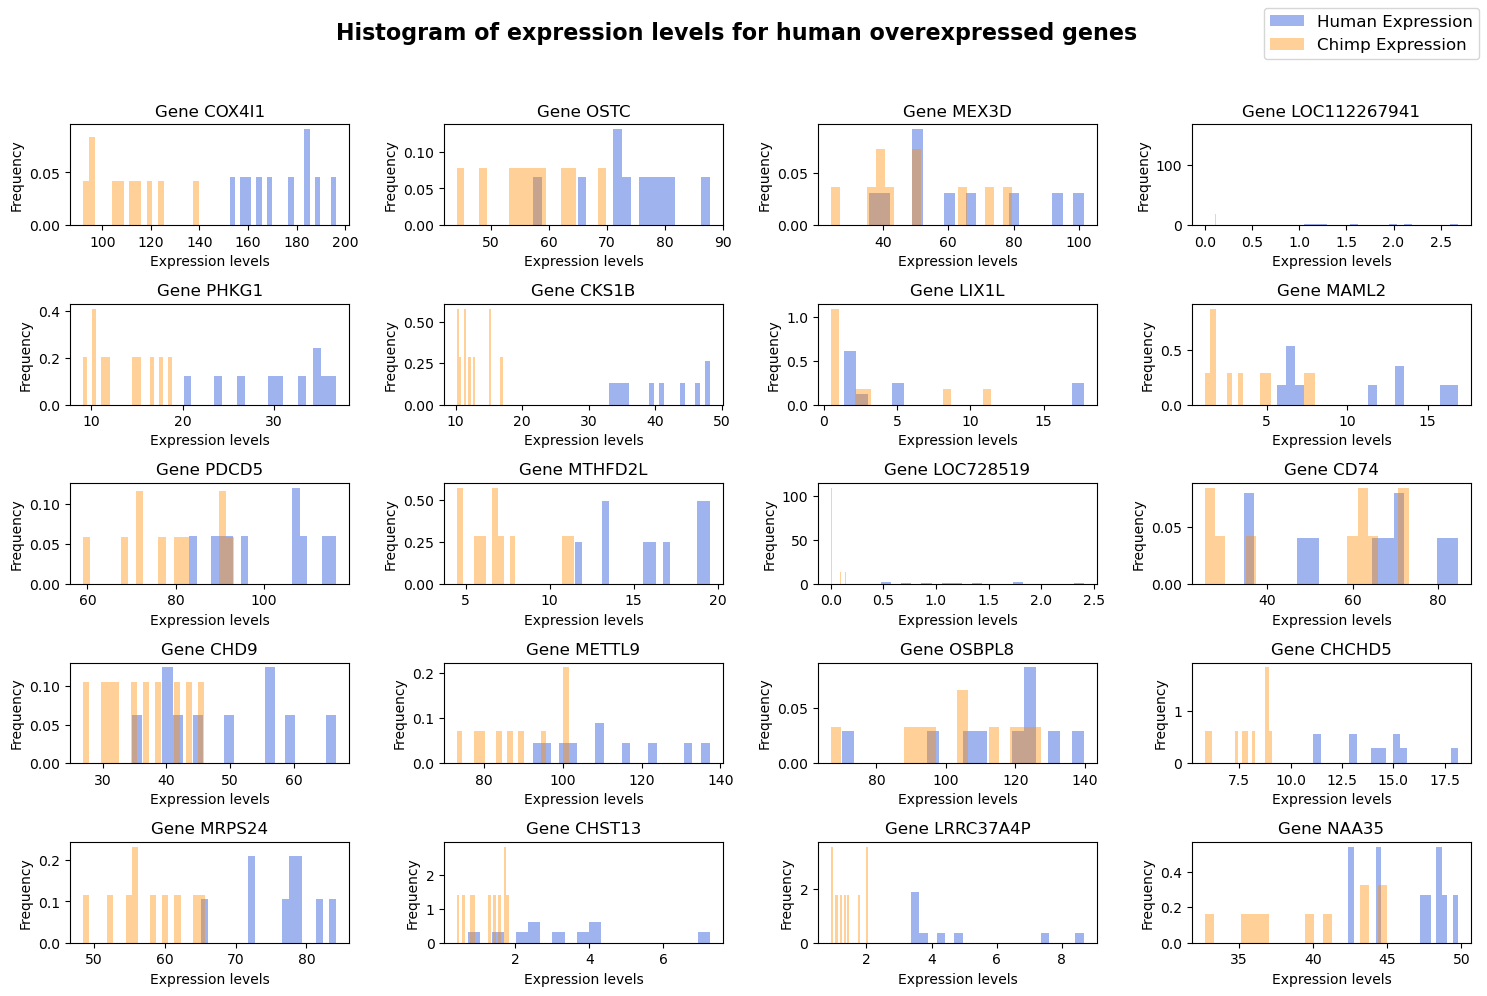

In [222]:
# np.random.seed(0)
SAMPLE_AMOUNT = 20
selected_genes = np.random.choice(top_60_overexpressed_genes, SAMPLE_AMOUNT, replace=False)

human_version_expression = HUMAN_COLOR
chimp_version_expression = CHIMP_COLOR

# plt.figure(figsize=(15, 10))
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 10))
fig.suptitle('Histogram of expression levels for human overexpressed genes', fontsize=16, fontweight='bold')
axes = axes.flatten()
for i, gene in enumerate(selected_genes):
    ax = axes[i]
    df_human_expression = normalized_df.loc[gene, intersect([HYBRIDS_SAMPLES, REF_COUNT, IPSC])]
    df_chimp_expression = normalized_df.loc[gene, intersect([HYBRIDS_SAMPLES, ALT_COUNT, IPSC])]

    ax.hist(df_human_expression, bins=20, alpha=0.5, label='Human Gene Expression', color=human_version_expression, density=True)
    ax.hist(df_chimp_expression, bins=20, alpha=0.4, label='Chimp Gene Expression', color=chimp_version_expression, density=True)
    ax.set_xlabel('Expression levels')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Gene {gene}')
    # ax.legend(loc='upper right')
fig.legend(["Human Expression", "Chimp Expression"], loc='upper right', fontsize='12', frameon=True, )
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

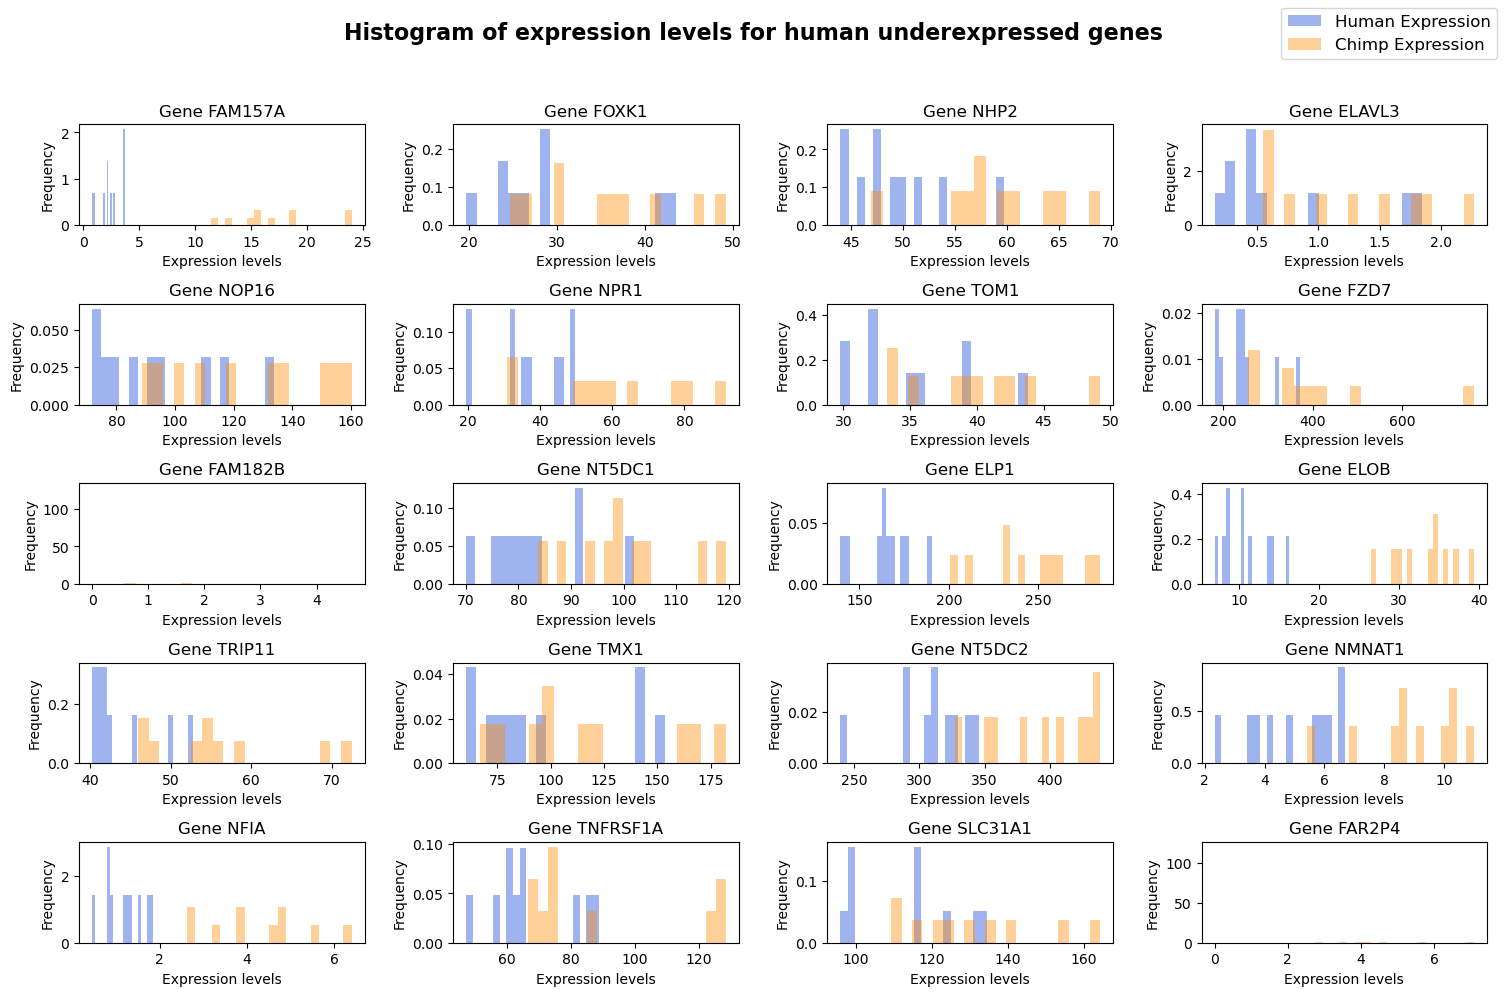

In [223]:
# np.random.seed(0)
SAMPLE_AMOUNT = 20
selected_genes = np.random.choice(top_60_underexpressed_genes, SAMPLE_AMOUNT, replace=False)

human_version_expression = HUMAN_COLOR
chimp_version_expression = CHIMP_COLOR

# plt.figure(figsize=(15, 10))
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 10))
fig.suptitle('Histogram of expression levels for human underexpressed genes', fontsize=16, fontweight='bold')
axes = axes.flatten()
for i, gene in enumerate(selected_genes):
    ax = axes[i]
    df_human_expression = normalized_df.loc[gene, intersect([HYBRIDS_SAMPLES, REF_COUNT, IPSC])]
    df_chimp_expression = normalized_df.loc[gene, intersect([HYBRIDS_SAMPLES, ALT_COUNT, IPSC])]

    ax.hist(df_human_expression, bins=20, alpha=0.5, label='Human Gene Expression', color=human_version_expression, density=True)
    ax.hist(df_chimp_expression, bins=20, alpha=0.4, label='Chimp Gene Expression', color=chimp_version_expression, density=True)
    ax.set_xlabel('Expression levels')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Gene {gene}')
    # ax.legend(loc='upper right')
fig.legend(["Human Expression", "Chimp Expression"], loc='upper right', fontsize='12', frameon=True, )
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

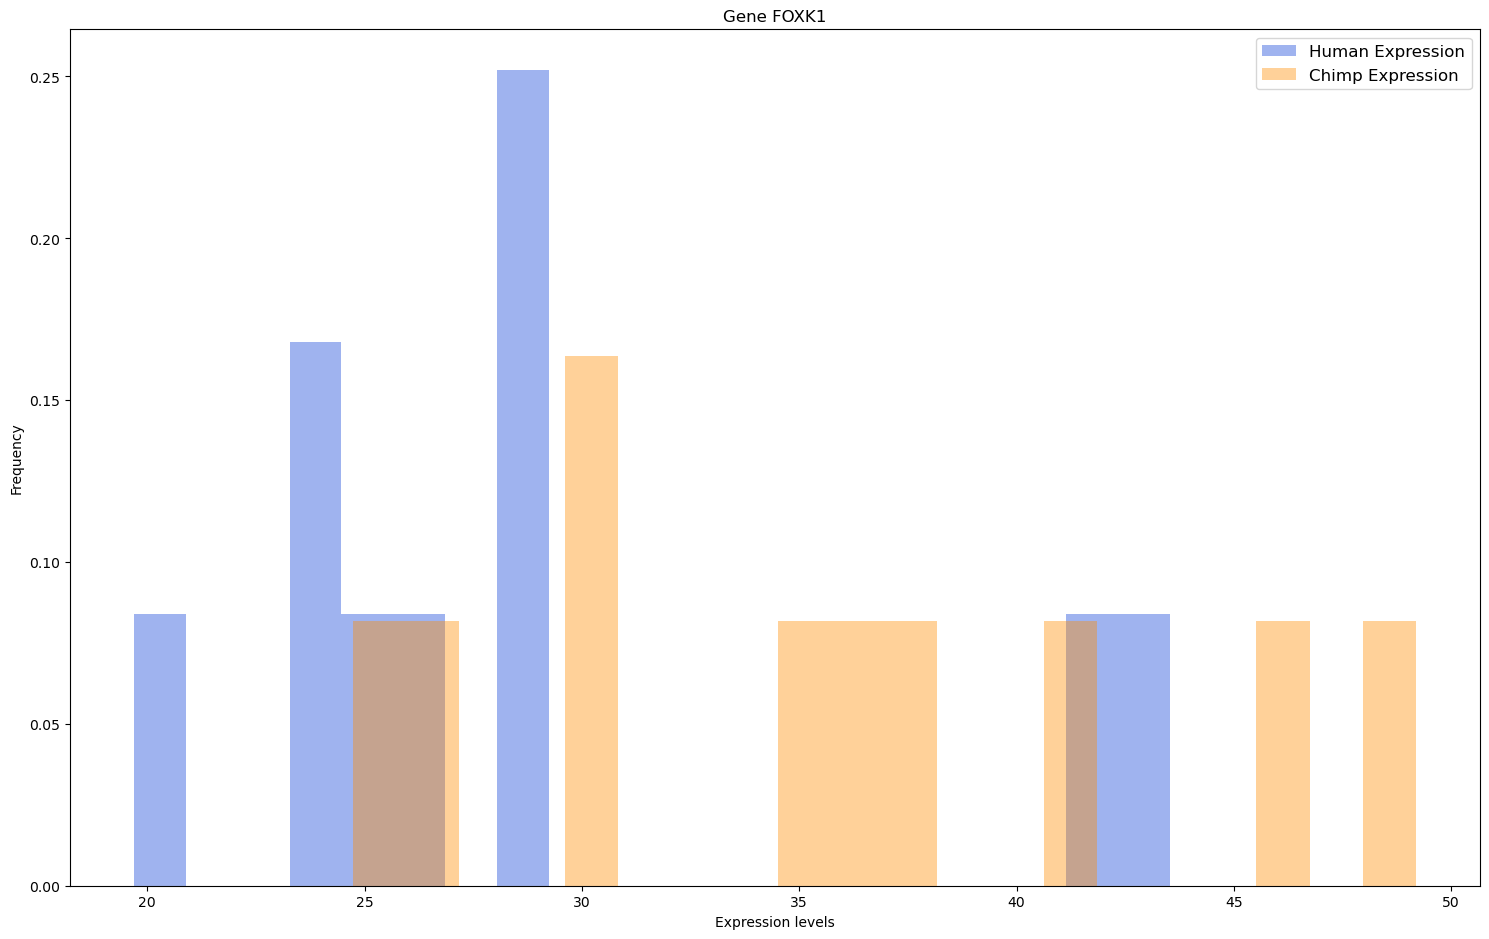

In [236]:

my_favorite_gene = 'FOXK1'
# np.random.seed(0)

human_version_expression = HUMAN_COLOR
chimp_version_expression = CHIMP_COLOR

plt.figure(figsize=(15, 10))
df_human_expression = normalized_df.loc[my_favorite_gene, intersect([HYBRIDS_SAMPLES, REF_COUNT, IPSC])]
df_chimp_expression = normalized_df.loc[my_favorite_gene, intersect([HYBRIDS_SAMPLES, ALT_COUNT, IPSC])]

plt.hist(df_human_expression, bins=20, alpha=0.5, label='Human Gene Expression', color=human_version_expression, density=True)
plt.hist(df_chimp_expression, bins=20, alpha=0.4, label='Chimp Gene Expression', color=chimp_version_expression, density=True)
plt.xlabel('Expression levels')
plt.ylabel('Frequency')
plt.title(f'Gene {my_favorite_gene}')
    # ax.legend(loc='upper right')
plt.legend(["Human Expression", "Chimp Expression"], loc='upper right', fontsize='12', frameon=True, )
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [288]:
p_values_DE_hybrids_paired_wilcoxon

LFC = pd.DataFrame(index=selected_wilcoxon_equivalent_genes, columns=['LFC'])
for gene in selected_wilcoxon_equivalent_genes: 
    refs_gene_avg = normalized_df.loc[gene, intersect([REF_COUNT, IPSC, HYBRIDS_SAMPLES])].dropna().mean()
    alts_gene_avg = normalized_df.loc[gene, intersect([ALT_COUNT, IPSC, HYBRIDS_SAMPLES])].dropna().mean()
    if (refs_gene_avg == 0 or alts_gene_avg == 0):
        LFC.loc[gene] = np.nan
    else:
        LFC.loc[gene] = np.log(refs_gene_avg / alts_gene_avg)

LFC = LFC.astype(float)
LFC.dropna(inplace=True)
selected_genes = LFC.index
p_values_DE_hybrids_paired_wilcoxon = p_values_DE_hybrids_paired_wilcoxon.loc[selected_genes, :].astype(float)
p_values_DE_hybrids_paired_wilcoxon['LFC'] = LFC
p_values_DE_hybrids_paired_wilcoxon['min_p_value'] = p_values_DE_hybrids_paired_wilcoxon[
    ['p_wilcoxon_human_overexpressed', 'p_wilcoxon_human_underexpressed']].min(axis=1)


In [314]:
list(top_60_overexpressed_genes[:5]) +list(top_60_underexpressed_genes[:5].values)

['ZSCAN10',
 'CNN2',
 'MAML2',
 'MAP1LC3B',
 'MCM3AP-AS1',
 'HSPH1',
 'FAM32A',
 'FAM213A',
 'FAM189A1',
 'FAM182B']

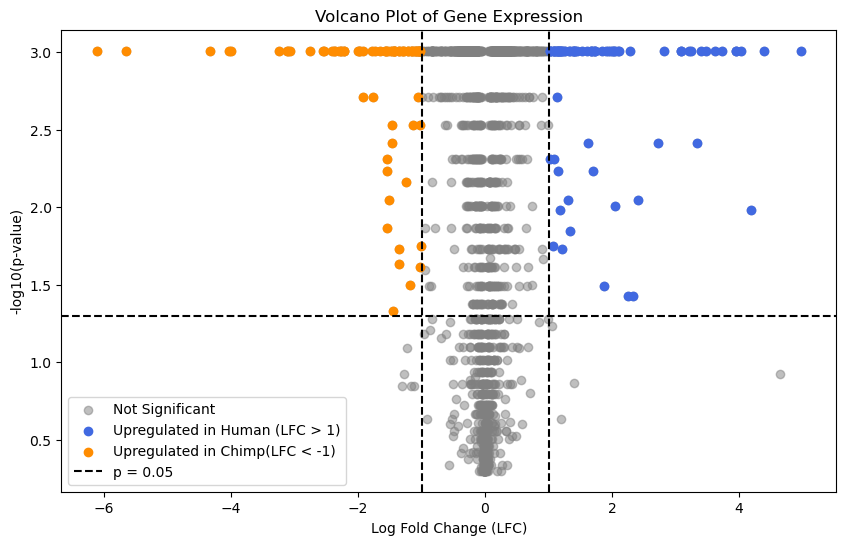

In [316]:
import matplotlib.pyplot as plt
import numpy as np



# special_genes = list(top_60_overexpressed_genes[:5]) + list(top_60_underexpressed_genes[:5])
special_genes = []
# special_genes = ['CHRNA5', 'FOXK1', 'ZSCAN10', 'MAML2','CHD9PCML', 'ELAVL3NRX', 'PDCD4', 'CHRNA5', 'CD74']


# Define thresholds for significance
p_value_threshold = 0.05
lfc_threshold = 1.0

# Compute -log10(p-value)
p_values_DE_hybrids_paired_wilcoxon['-log10(p-value)'] = -np.log10(p_values_DE_hybrids_paired_wilcoxon['min_p_value'])

# Define significance conditions
significant_up = (p_values_DE_hybrids_paired_wilcoxon['p_wilcoxon_human_overexpressed'] < p_value_threshold) & (p_values_DE_hybrids_paired_wilcoxon['LFC'] > lfc_threshold)
significant_down = (p_values_DE_hybrids_paired_wilcoxon['p_wilcoxon_human_underexpressed'] < p_value_threshold) & (p_values_DE_hybrids_paired_wilcoxon['LFC'] < -lfc_threshold)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(p_values_DE_hybrids_paired_wilcoxon['LFC'], 
            p_values_DE_hybrids_paired_wilcoxon['-log10(p-value)'], 
            color='gray', alpha=0.5, label='Not Significant')

plt.scatter(p_values_DE_hybrids_paired_wilcoxon.loc[significant_up, 'LFC'], 
            p_values_DE_hybrids_paired_wilcoxon.loc[significant_up, '-log10(p-value)'], 
            color=HUMAN_COLOR, label='Upregulated in Human (LFC > 1)')

plt.scatter(p_values_DE_hybrids_paired_wilcoxon.loc[significant_down, 'LFC'], 
            p_values_DE_hybrids_paired_wilcoxon.loc[significant_down, '-log10(p-value)'], 
            color=CHIMP_COLOR, label='Upregulated in Chimp(LFC < -1)')

# Add labels and threshold lines
plt.axhline(-np.log10(p_value_threshold), color='black', linestyle='dashed', label=f'p = {p_value_threshold}')
plt.axvline(-lfc_threshold, color='black', linestyle='dashed')
plt.axvline(lfc_threshold, color='black', linestyle='dashed')

plt.xlabel('Log Fold Change (LFC)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot of Gene Expression')
plt.legend()



# Highlight special genes
for gene in special_genes:
    if gene in p_values_DE_hybrids_paired_wilcoxon.index:
        plt.annotate(
            gene,  # Text label
            (p_values_DE_hybrids_paired_wilcoxon.loc[gene, 'LFC'],
            p_values_DE_hybrids_paired_wilcoxon.loc[gene, '-log10(p-value)']),  # Position in the plot
            textcoords="offset points",
            xytext=(5,5),  # Offset for readability
            ha='left',
            fontsize=10,
            # color='red',
            fontweight='bold'
        )
        plt.scatter(p_values_DE_hybrids_paired_wilcoxon.loc[gene, 'LFC'],
                    p_values_DE_hybrids_paired_wilcoxon.loc[gene, '-log10(p-value)'], 
                    edgecolors='black', s=80, label=gene)





plt.show()
